# Machine Learning Project 4 - Medical Insurance Cost Prediction

In [157]:
# Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
import math
import re
df=pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [127]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [129]:
# Checking for null values, if there taking total of null values 
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [131]:
# Checking any duplicated values
df.duplicated().sum()

1

In [135]:
# Dropping duplicate rows
df.drop_duplicates(inplace=True)

In [137]:
# Rechecking any duplicated values
df.duplicated().sum()

0

In [139]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


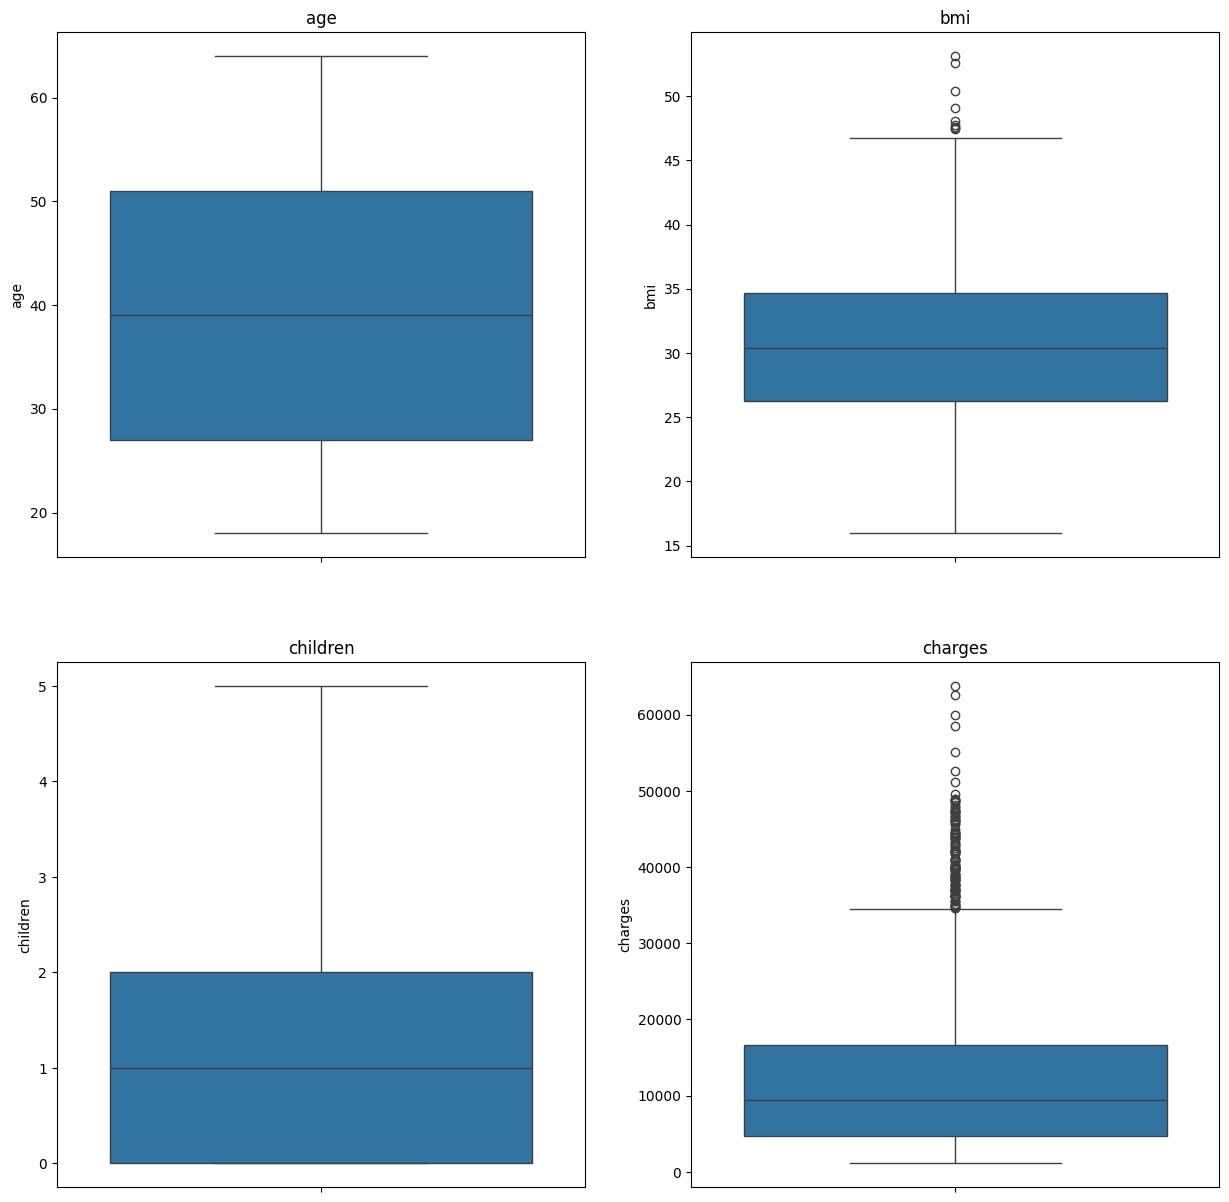

In [141]:
# Checking outliers in numerical columns using boxplot
plt.figure(figsize=(15,15))
Numericals=['age','bmi','children','charges']
plot=1
for i in Numericals:
    plt.subplot(2,2,plot)
    sns.boxplot(df[i])
    plt.title(i)
    plot+=1

In [143]:
# Removing outliers using IQR method
Numericals=['age','bmi','children','charges']
for i in Numericals:
    flag=True
    while(flag):
        q25,q75=np.percentile(df[i],[25,75])
        IQR=q75-q25
        lower_limit=q25-1.5*IQR
        upper_limit=q75+1.5*IQR
        if(df[i]<lower_limit).sum() or (df[i]>upper_limit).sum():
            df[i]=np.where(df[i]>upper_limit,upper_limit,df[i])
            df[i]=np.where(df[i]<lower_limit,upper_limit,df[i])
            flag=True
        else:
            flag=False

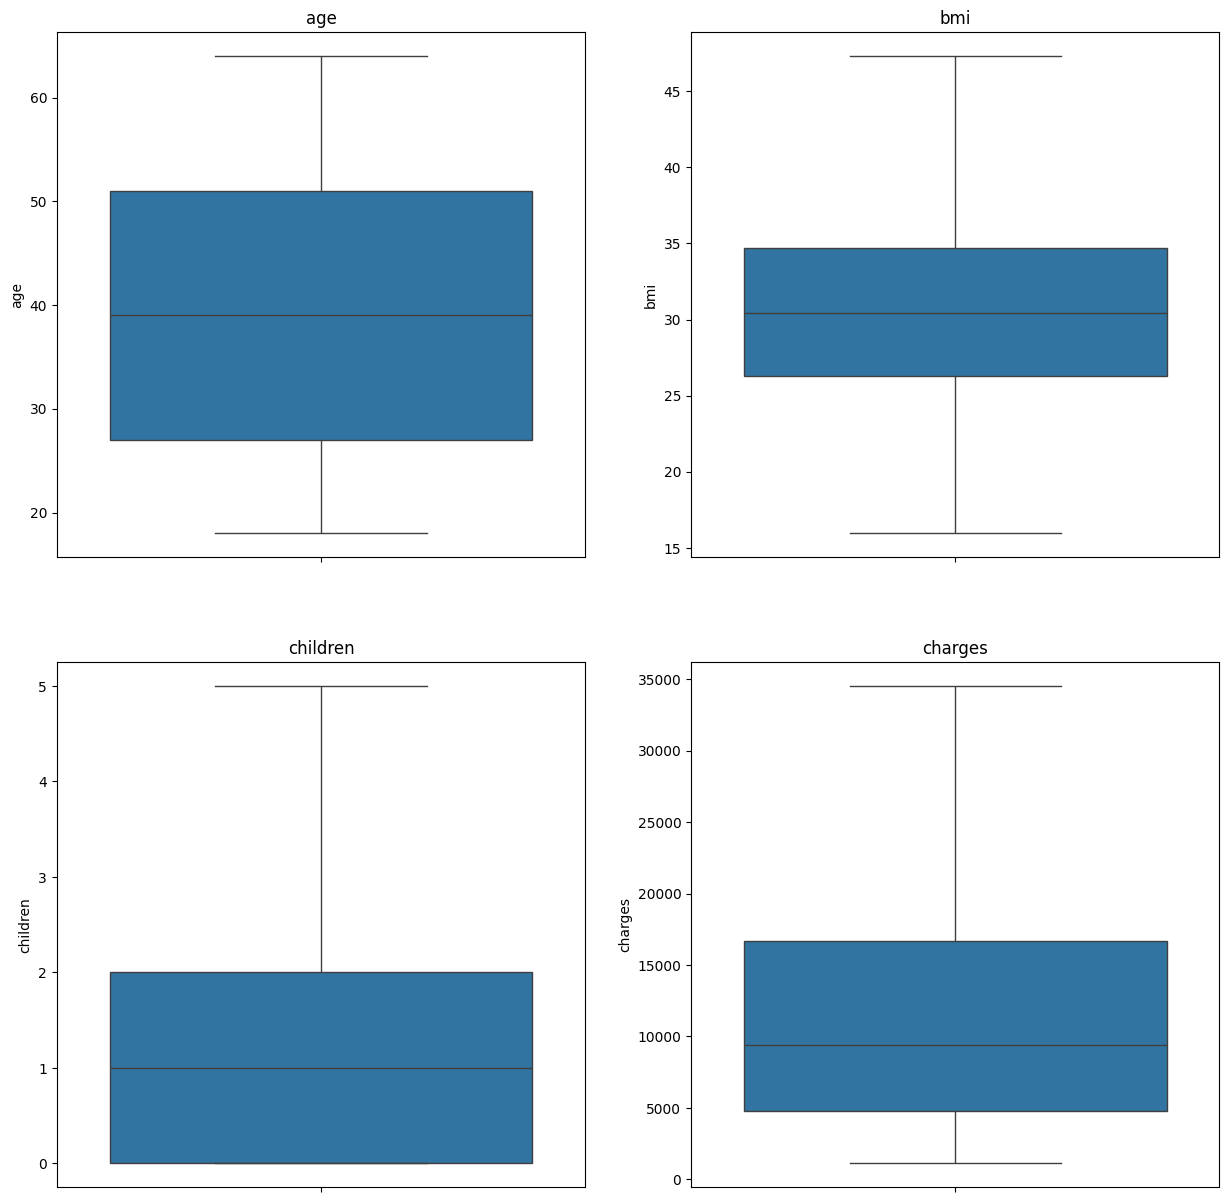

In [145]:
# Rechecking outliers using boxplot
plt.figure(figsize=(15,15))
Numericals=['age','bmi','children','charges']
plot=1
for i in Numericals:
    plt.subplot(2,2,plot)
    sns.boxplot(df[i])
    plt.title(i)
    plot+=1

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [149]:
# Converting categorical columns into numerical columns using LabelEncoder
le=LabelEncoder()
categorical=['sex','smoker','region']
for i in categorical:
    df[i]=le.fit_transform(df[i])

In [151]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


In [153]:
# Split -Dependent and Independent Variables
x=df.drop(['charges'],axis=1)
x

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1
1334,18,0,31.920,0,0,0
1335,18,0,36.850,0,0,2
1336,21,0,25.800,0,0,3


In [155]:
y=df.charges
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1337, dtype: float64

In [161]:
# Cross Validation Using cross_val_score
cross = {
    'Linear': {'model': LinearRegression()},
    'Decision': {'model': DecisionTreeRegressor()},
    'Random': {'model': RandomForestRegressor()},
    'SVR': {'model': SVR()},
    'Catboost': {"model": CatBoostRegressor()},
    'KNeighbour': {"model": KNeighborsRegressor()}
}

mse_values = []

for model_name, model_info in cross.items():
    cvs = cross_val_score(model_info['model'], X=x, y=y, cv=10, scoring="neg_mean_squared_error", n_jobs=-1)
    mse = -np.mean(cvs)
    mse_values.append({'model': model_name, 'mean_squared_error': mse})

for model_result in mse_values:
    print(f"{model_result['model']} - Mean Squared Error: {model_result['mean_squared_error']}")

Linear - Mean Squared Error: 26344739.925686527
Decision - Mean Squared Error: 39046232.86793589
Random - Mean Squared Error: 21496992.062020846
SVR - Mean Squared Error: 112838194.98313442
Catboost - Mean Squared Error: 20415605.672235336
KNeighbour - Mean Squared Error: 90510917.96915731


In [163]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=48)
print(len(xtrain), len(ytrain))
print(len(xtest), len(ytest))

1069 1069
268 268


In [167]:
# Hypertinning using RandomizedSearchcv
# Random Forest Hyperparameter Tuning
rf_param_dist = {
    'n_estimators': [500, 1000],
    'max_depth': [20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2']}

rf_model = RandomForestRegressor()
rf_search = RandomizedSearchCV(rf_model, rf_param_dist, n_iter=10, cv=2, n_jobs=-1, random_state=42)
print("Tuning RandomForest...")
rf_search.fit(xtrain, ytrain)

rf_score = {
    'model': 'RandomForest',
    'best_params': rf_search.best_params_,
    'best_score': rf_search.best_score_
}
print("RandomForest tuning completed!")

# CatBoost Hyperparameter Tuning
catboost_param_dist = {
    'iterations': [500, 1000],
    'depth': [6, 10],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3] }

catboost_model = CatBoostRegressor()
catboost_search = RandomizedSearchCV(catboost_model, catboost_param_dist, n_iter=10, cv=2, n_jobs=-1, random_state=42)
print("Tuning CatBoost...")
catboost_search.fit(xtrain, ytrain)

catboost_score = {
    'model': 'CatBoost',
    'best_params': catboost_search.best_params_,
    'best_score': catboost_search.best_score_
}
print("CatBoost tuning completed!")

# Linear Regression Hyperparameter Tuning
lr_param_dist = {
    'fit_intercept': [True, False] }

lr_model = LinearRegression()
lr_search = RandomizedSearchCV(lr_model, lr_param_dist, n_iter=10, cv=2, n_jobs=-1, random_state=42)
print("Tuning Linear Regression...")
lr_search.fit(xtrain, ytrain)

lr_score = {
    'model': 'Linear Regression',
    'best_params': lr_search.best_params_,
    'best_score': lr_search.best_score_
}
print("Linear Regression tuning completed!")

scores = [rf_score, catboost_score, lr_score]
for score in scores:
    print(f"{score['model']} - Best Parameters: {score['best_params']}, Best Score: {score['best_score']}")

Tuning RandomForest...
RandomForest tuning completed!
Tuning CatBoost...
0:	learn: 10159.5776989	total: 2.17ms	remaining: 1.08s
1:	learn: 10082.0171799	total: 4.34ms	remaining: 1.08s
2:	learn: 10011.6194954	total: 5.38ms	remaining: 891ms
3:	learn: 9938.4213205	total: 7.53ms	remaining: 934ms
4:	learn: 9862.3562115	total: 9.6ms	remaining: 950ms
5:	learn: 9787.2629952	total: 11.5ms	remaining: 946ms
6:	learn: 9716.1422791	total: 13.4ms	remaining: 947ms
7:	learn: 9643.1889998	total: 15.4ms	remaining: 945ms
8:	learn: 9571.2171619	total: 17.2ms	remaining: 940ms
9:	learn: 9503.0167051	total: 19.1ms	remaining: 935ms
10:	learn: 9439.4914084	total: 20ms	remaining: 888ms
11:	learn: 9371.0712455	total: 21.9ms	remaining: 889ms
12:	learn: 9305.2975997	total: 23.6ms	remaining: 885ms
13:	learn: 9242.7923867	total: 24.5ms	remaining: 849ms
14:	learn: 9177.2568914	total: 26.5ms	remaining: 857ms
15:	learn: 9115.7551168	total: 27.5ms	remaining: 833ms
16:	learn: 9048.6666533	total: 29.4ms	remaining: 836ms
17

In [169]:
scores

[{'model': 'RandomForest',
  'best_params': {'n_estimators': 500,
   'min_samples_split': 5,
   'min_samples_leaf': 2,
   'max_features': 'log2',
   'max_depth': 30},
  'best_score': 0.8028480255931227},
 {'model': 'CatBoost',
  'best_params': {'learning_rate': 0.01,
   'l2_leaf_reg': 1,
   'iterations': 500,
   'depth': 6},
  'best_score': 0.8195154433024389},
 {'model': 'Linear Regression',
  'best_params': {'fit_intercept': True},
  'best_score': 0.7492598164357757}]

In [171]:
model = CatBoostRegressor(learning_rate=0.01, l2_leaf_reg=1,iterations=500, depth=6)
model.fit(xtrain,ytrain)

0:	learn: 10159.5776989	total: 1.92ms	remaining: 956ms
1:	learn: 10082.0171799	total: 3.98ms	remaining: 991ms
2:	learn: 10011.6194954	total: 5.11ms	remaining: 846ms
3:	learn: 9938.4213205	total: 7.06ms	remaining: 876ms
4:	learn: 9862.3562115	total: 8.97ms	remaining: 888ms
5:	learn: 9787.2629952	total: 10.7ms	remaining: 880ms
6:	learn: 9716.1422791	total: 12.5ms	remaining: 881ms
7:	learn: 9643.1889998	total: 14.3ms	remaining: 878ms
8:	learn: 9571.2171619	total: 16.4ms	remaining: 894ms
9:	learn: 9503.0167051	total: 18.3ms	remaining: 897ms
10:	learn: 9439.4914084	total: 19.1ms	remaining: 849ms
11:	learn: 9371.0712455	total: 20.9ms	remaining: 851ms
12:	learn: 9305.2975997	total: 23ms	remaining: 862ms
13:	learn: 9242.7923867	total: 23.8ms	remaining: 825ms
14:	learn: 9177.2568914	total: 25.8ms	remaining: 834ms
15:	learn: 9115.7551168	total: 27ms	remaining: 815ms
16:	learn: 9048.6666533	total: 28.9ms	remaining: 821ms
17:	learn: 8983.7611418	total: 92.5ms	remaining: 2.48s
18:	learn: 8918.94148

In [173]:
xtrain

,age,sex,bmi,children,smoker,region
656,26,0,42.400,1,0,3
516,20,1,35.310,1,0,2
226,28,1,38.060,0,0,2
149,19,1,28.400,1,0,3
11,62,0,26.290,0,1,2
...,...,...,...,...,...,...
454,32,1,46.530,2,0,2
967,44,1,25.365,1,0,1
945,56,0,35.800,1,0,3
347,46,1,33.345,1,0,0


In [175]:
ytrain

656     3410.32400
516    27724.28875
226     2689.49540
149     1842.51900
11     27808.72510
          ...     
454     4686.38870
967     7518.02535
945    11674.13000
347     8334.45755
563     9058.73030
Name: charges, Length: 1069, dtype: float64

In [177]:
model.score(xtest,ytest)

0.8098928330043669

In [221]:
# testing with existing data
output1 = model.predict([[26,0,42.400,1,0,3]])[0]
output1 

4047.8870100782897

In [223]:
# testing with existing data
output2 = model.predict([[20,1,35.310,1,0,2]])[0]
output2 

4273.052450463667

In [225]:
# giving new data for predicition
output3 = model.predict([[35,0,45.310,3,1,2]])[0]
output3 

33795.960304878914

In [227]:
# giving new data for predicition
output4 = model.predict([[55,1,41.110,2,0,1]])[0]
output4 

15912.310412503019

In [179]:
ypred=model.predict(xtest)
ypred

array([ 5391.75963134,  3688.41963713,  5923.93123512,  4257.94384577,
       13816.68874666, 24328.11113259, 30929.15981404,  6453.85933839,
       14083.87622942,  8342.09179056, 14477.51706163, 29387.96934709,
        3383.37587112,  3633.72327381, 11869.09970698, 12857.21346753,
       27458.0867847 , 33689.2769029 ,  5153.88488025, 12313.19920785,
        7826.56207823,  3191.04643479, 16838.74207436,  7262.08630634,
       12645.86478761,  2798.38289224,  5720.70146608, 13258.10975312,
        3922.59794792,  8367.67965302, 25824.35252677,  3642.33385542,
        7411.81346698,  7020.1555613 ,  5694.50771548,  2976.57248041,
        5345.22460891,  3877.67524205, 11223.27005235, 24022.41707725,
        3545.10526547,  4863.80737295, 12036.55866223, 17480.12178248,
       17429.84202556, 14038.788421  ,  7765.2479508 ,  3378.21901477,
        6779.70686769,  3272.48342853,  4757.96589183,  8708.28216072,
       11532.78219507,  9058.73876122, 12423.61886793,  3757.47448255,
      

In [181]:
mse=mean_squared_error(ytest,ypred)
rmse=math.sqrt(mse)
print("Mean Square Error:-",mse)
print("Root Mean Square Error:-",rmse)

Mean Square Error:- 18484910.691820577
Root Mean Square Error:- 4299.408179252184


In [185]:
cat_evs=explained_variance_score(ytest,ypred)
print("Explained Variance score:-",cat_evs)

Explained Variance score:- 0.8100502256015572


In [187]:
# Random Forest
model1=RandomForestRegressor(n_estimators=500, min_samples_split=5, min_samples_leaf=2, max_features='log2', max_depth=30)
model1.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=30, max_features='log2', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=500)

In [189]:
xtrain

,age,sex,bmi,children,smoker,region
656,26,0,42.400,1,0,3
516,20,1,35.310,1,0,2
226,28,1,38.060,0,0,2
149,19,1,28.400,1,0,3
11,62,0,26.290,0,1,2
...,...,...,...,...,...,...
454,32,1,46.530,2,0,2
967,44,1,25.365,1,0,1
945,56,0,35.800,1,0,3
347,46,1,33.345,1,0,0


In [191]:
ytrain

656     3410.32400
516    27724.28875
226     2689.49540
149     1842.51900
11     27808.72510
          ...     
454     4686.38870
967     7518.02535
945    11674.13000
347     8334.45755
563     9058.73030
Name: charges, Length: 1069, dtype: float64

In [193]:
model1.score(xtest,ytest)

0.7986119598384286

In [233]:
# testing with existing data
output1 = model1.predict([[26,0,42.400,1,0,3]])[0]
output1 

4824.757431827973

In [235]:
# testing with existing data
output2 = model1.predict([[20,1,35.310,1,0,2]])[0]
output2 

9921.662533985611

In [241]:
# giving new data for predicition
output3 = model1.predict([[35,0,45.310,3,1,2]])[0]
output3 

31775.220141771842

In [245]:
# giving new data for predicition
output4 = model1.predict([[55,1,41.110,2,0,1]])[0]
output4 

17719.17102327015

In [195]:
ypred=model1.predict(xtest)
ypred

array([ 5680.57142205,  3878.59799185,  5990.60046474,  4317.98750329,
       12958.80500806, 23889.18750475, 30239.12254364,  8203.92512243,
       12924.6384486 ,  8061.72057344, 14986.49209907, 28932.20409198,
        4140.69226474,  4325.25956285, 12395.80738164, 13109.45847216,
       27386.07009   , 30689.77275756,  6011.18473265, 12403.79496236,
        8168.06926322,  4330.90893921, 17080.3246101 ,  8572.47012361,
       12486.40774938,  2608.23235222,  6901.25391083, 13236.29902273,
        4525.00815412,  8816.24234949, 26130.68201612,  3057.04595999,
        8529.59132315,  8247.39515385,  5650.73663454,  3693.44000424,
        7002.11914977,  3471.78090105, 11246.95109903, 24591.92810221,
        3190.37690305,  6649.35709916, 12300.67886933, 18207.07485856,
       18218.84291235, 14097.16318017,  8523.54566586,  4166.33026688,
        6975.46520064,  3157.25279451,  4398.75277757, 10150.22040554,
       12384.23128498,  9162.53169401, 11624.59035111,  4199.70352223,
      

In [197]:
mse=mean_squared_error(ytest,ypred)
rmse=math.sqrt(mse)
print("Mean Square Error:-",mse)
print("Root Mean Square Error:-",rmse)

Mean Square Error:- 19581796.918118995
Root Mean Square Error:- 4425.132418145134


In [199]:
random_evs=explained_variance_score(ytest,ypred)
print("Explained Variance score:-",random_evs)

Explained Variance score:- 0.7986192207501361


In [201]:
# linear
model2= LinearRegression(fit_intercept=True)
model2.fit(xtrain,ytrain)

LinearRegression()

In [203]:
xtrain

,age,sex,bmi,children,smoker,region
656,26,0,42.400,1,0,3
516,20,1,35.310,1,0,2
226,28,1,38.060,0,0,2
149,19,1,28.400,1,0,3
11,62,0,26.290,0,1,2
...,...,...,...,...,...,...
454,32,1,46.530,2,0,2
967,44,1,25.365,1,0,1
945,56,0,35.800,1,0,3
347,46,1,33.345,1,0,0


In [205]:
ytrain

656     3410.32400
516    27724.28875
226     2689.49540
149     1842.51900
11     27808.72510
          ...     
454     4686.38870
967     7518.02535
945    11674.13000
347     8334.45755
563     9058.73030
Name: charges, Length: 1069, dtype: float64

In [207]:
model2.score(xtest,ytest)

0.7349982319732287

In [237]:
# testing with existing data
output1 = model2.predict([[26,0,42.400,1,0,3]])[0]
output1 

7552.130152393418

In [239]:
# testing with existing data
output2 = model2.predict([[20,1,35.310,1,0,2]])[0]
output2 

4872.683967296891

In [243]:
# giving new data for predicition
output3 = model2.predict([[35,0,45.310,3,1,2]])[0]
output3 

31497.66338390897

In [247]:
# giving new data for predicition
output4 = model2.predict([[55,1,41.110,2,0,1]])[0]
output4 

14706.126129388294

In [209]:
ypred=model2.predict(xtest)
ypred

array([ 4968.47596371,  2853.47573922,  6222.77427569,  5284.77534936,
       13077.93289524, 30313.5677178 , 26281.7423025 , 10539.93876928,
       12108.12690826,  9121.3231411 , 13284.98896175, 27352.9540926 ,
        2830.39530915,  2798.12497219, 10698.54588007, 12027.70821617,
       30361.87472556, 24841.46701542,  7128.06497988, 11704.16071162,
        8118.41381109,  4907.75063886, 15101.39042962,  6956.72626661,
       12295.06490771,  2000.67499927,  7675.70736817, 13384.42495394,
        3284.97168636,  7126.35245362, 24779.65944842,  4566.36825549,
        7655.15257345,  8723.06502186,  6336.46978649,  2186.88205209,
        4308.30344861,  3130.99958199, 10455.60553989, 30141.87032756,
        1808.13457852,  8899.08805085, 10264.48957755, 23900.47092436,
       23446.31489581, 14415.43951643, 10201.1521298 ,   600.70890475,
        8740.04404902,  5647.25426879,  7560.82247029, 10458.60623412,
       10847.16955773,  7755.32082752, 12038.22339326,  4541.04272899,
      

In [211]:
mse=mean_squared_error(ytest,ypred)
rmse=math.sqrt(mse)
print("Mean Square Error:-",mse)
print("Root Mean Square Error:-",rmse)

Mean Square Error:- 25767224.311232522
Root Mean Square Error:- 5076.142660646224


In [213]:
lin_evs=explained_variance_score(ytest,ypred)
print("Explained Variance score:-",lin_evs)

Explained Variance score:- 0.7349985092307336


Text(0, 0.5, 'EVS Score')

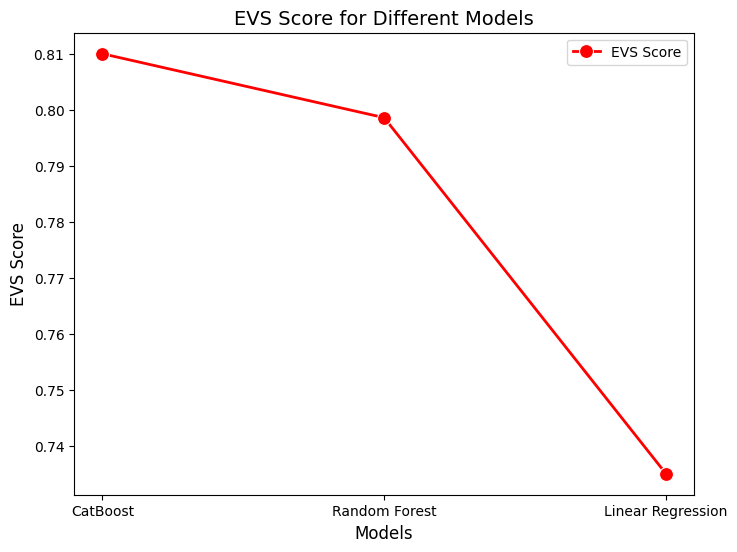

In [215]:
evs_score = [0.8100502256015572, 0.7986192207501361, 0.7349985092307336]
models = ['CatBoost', 'Random Forest', 'Linear Regression']

plt.figure(figsize=(8, 6))

sns.lineplot(x=models, y=evs_score, marker='o', color='red', linewidth=2, label='EVS Score',markersize=10)

plt.title('EVS Score for Different Models', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('EVS Score', fontsize=12)


Text(0, 0.5, 'MSE Score')

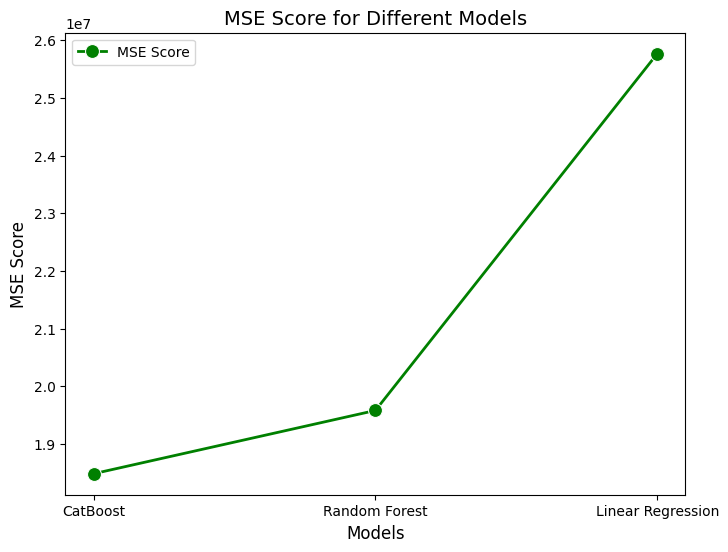

In [217]:
mse=[18484910.691820577,19581796.918118995,25767224.311232522]
models = ['CatBoost', 'Random Forest', 'Linear Regression']

plt.figure(figsize=(8, 6))

sns.lineplot(x=models, y=mse, marker='o', color='green', linewidth=2, label='MSE Score',markersize=10)

plt.title('MSE Score for Different Models', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MSE Score', fontsize=12)


Text(0, 0.5, 'RMSE Score')

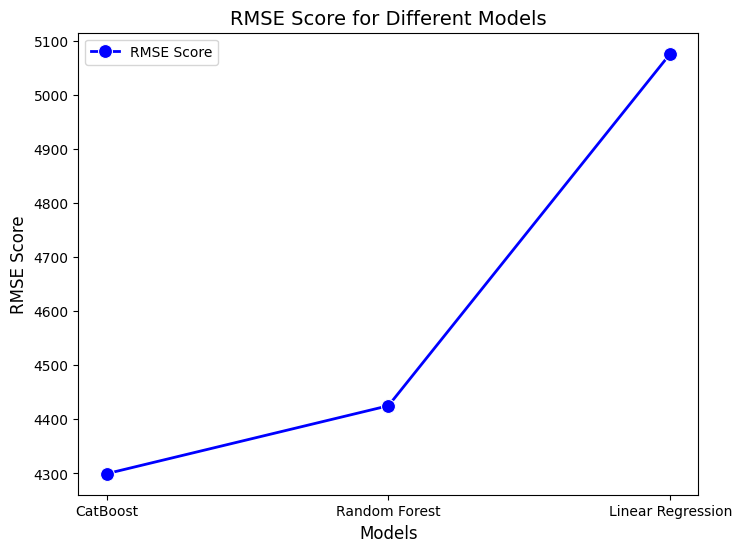

In [219]:
rmse=[4299.408179252184,4425.132418145134,5076.142660646224]
models = ['CatBoost', 'Random Forest', 'Linear Regression']

plt.figure(figsize=(8, 6))

sns.lineplot(x=models, y=rmse, marker='o', color='blue', linewidth=2, label='RMSE Score',markersize=10)

plt.title('RMSE Score for Different Models', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('RMSE Score', fontsize=12)